# Baseline Apprach
For our baseline, a straightforward attempt at interpolation is simply the average of the two frames that are being interpolated.

### Loading dataset

In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def visualize_frames_baseline(x1, x2, y, y_hat):
    H, L, W = x1.shape
    order = [x1, x2, y, y_hat]
    x = [i[H//4 * 2, :, :] for i in order]
    y = [z_stretch(i[:, L//4 * 2, :]) for i in order]
    z = [z_stretch(i[:, :, W//4 * 2]) for i in order]
    slices = x + y + z
    display_grid(3,4,slices)

In [29]:
set_figsize(20, 15)

In [30]:
validation = TAVR_3_Frame("__valid")

In [31]:
def pred(x1, x2):
    return (x1 + x2)/ 2

### Loss
For our loss function, we simply take the L2 loss between the predicted frame and the actual frame.

In [5]:
def loss(y_hat, y): #, D, max_z):
    L2 = (y_hat - y) ** 2
#     norm = L2 * D
#     scale = norm/max_z
    ret = torch.sqrt(torch.sum(L2))/torch.prod(torch.tensor(y.shape)).type(torch.float)
    return ret.numpy()

In [6]:
for bunch in validation:
    x1, y, x2 = bunch
    single_loss = loss(pred(x1, x2), y)#, D, max_z)
    print(single_loss)

0.017203733
0.01792571
0.016858703
0.01548136
0.015628789
0.016526354
0.01749194
0.018419715
0.02083058
0.021232322
0.020496512
0.01949804
0.019305656
0.019166939
0.017754218
0.017019663
0.016700266
0.016071804


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


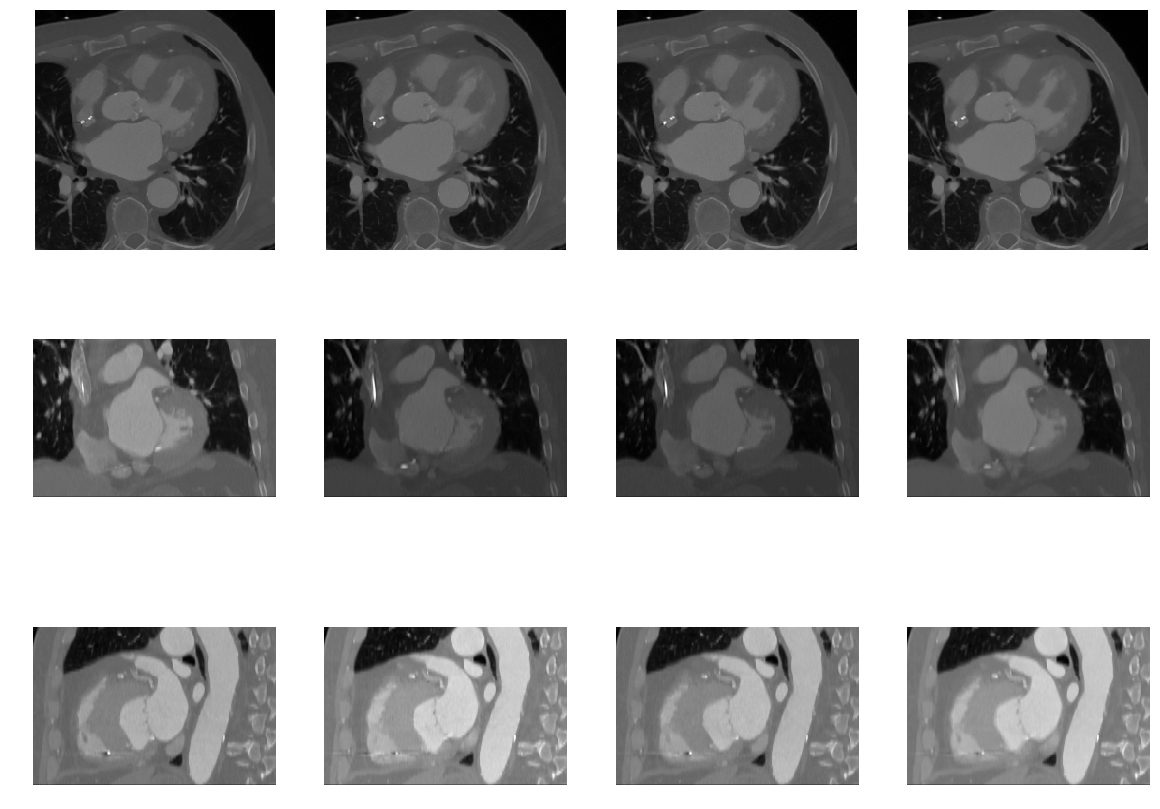

In [32]:
x1, y, x2 = validation[len(validation)//2]

visualize_frames_baseline(x1, x2, y, pred(x1, x2))

In [23]:
class average_model(nn.Module):
    def forward(self, X):
        x1, x2 = X
        return (x1 + x2)/ 2

class batch_loss(nn.Module):
    def forward(self, results):
        y, y_hat, D, max_z = results
        L2 = (y - y_hat)**2 * D
        L2_total = torch.sqrt(torch.sum(L2))
        L2_ave = L2_total/(torch.sum(max_z) * 256 * 256)
        return L2_ave, np.sqrt(torch.max(L2).numpy()), L2_total.numpy()
        

In [24]:
val_loader = tavr_dataloader(validation, batch_size=8, shuffle=True, num_workers=4)
model = average_model()
L2_loss = batch_loss()

In [25]:
for batch in val_loader:
    x1, y, x2, D, max_z = batch
    y_hat = model((x1, x2))
    loss, maxloss, total = L2_loss((y, y_hat, D, max_z))
    print(loss.numpy(), maxloss, total)

0.0061311405 3502.0 215370.39
0.006574295 3696.0 230937.2
0.01321936 3606.0 116090.09


In [ ]:
class BestModel(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, channel_3, channel_4, num_classes):
        super().__init__()
        